## 数据集:http://download.caffe2.ai/database/mnist-lmdb.zip

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import operator
import caffe2.python.predictor.predictor_exporter as pe
# from caffe2.python import core
from caffe2.python import brew, core, model_helper, net_drawer, optimizer, visualize, workspace

# caffe2初始化细节:caffe2_log_level=1
core.GlobalInit(["caffe2", "--caffe2_log_level=1"])
USE_LENET_MODEL = True

In [2]:
directory = os.path.dirname(__name__)
print("directory: {}".format(directory))
print("type: {}".format(type(directory)))
print("len: {}".format(len(directory)))
pathes = os.path.abspath(directory)
print("----")
print(pathes)

directory: 
type: <class 'str'>
len: 0
----
/home/xdq/xinPrj/python/jupyter/Caffe2Pytorch


# download datasets and create store folder

In [3]:
def DownloadResource(url, path):
    import requests, zipfile, urllib, subprocess
    print("Downloading...{} to {}".format(url, path))
#     r = requests.get(url, stream=True)
    file_path, _ = urllib.request.urlretrieve(url, path)
#     z = zipfile.ZipFile(StringIO.StringIO(r.content))
#     z.extractall(path)
#     cmd = ['unzip', '-d', path]
    print("Completed download and extraction.")

current_folder = os.path.abspath(os.path.dirname(__name__))
data_folder = os.path.join(current_folder, "turorial_data", "mnist")
root_folder = os.path.join(current_folder, "turorial_files", "tutorial_mnist")
db_missing = False
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
if os.path.exists(os.path.join(data_folder, "mnist-train-nchw-lmdb")):
    print("lmdb train db found!")
if os.path.exists(root_folder):
    shutil.rmtree(root_folder)

os.makedirs(root_folder)
workspace.ResetWorkspace(root_folder)
print("training data folder:" + data_folder)
print("workspace root folder:" + root_folder)


lmdb train db found!
training data folder:/home/xdq/xinPrj/python/jupyter/Caffe2Pytorch/turorial_data/mnist
workspace root folder:/home/xdq/xinPrj/python/jupyter/Caffe2Pytorch/turorial_files/tutorial_mnist


In [4]:
def AddInput(model, batch_size, db, db_type):
    data_uint8, label = model.TensorProtosDBInput([], ["data_uint8", "label"], batch_size=batch_size,
                                                 db=db, db_type=db_type)
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    data = model.Scale(data, data, scale=float(1./256))
    data = model.StopGradient(data, data)
    return data, label

In [5]:
def AddMLPModel(model, data):
    size = 28*28*1
    sizes = [size, size*2, size*2, 10]
    layer = data
    for i in range(len(sizes)-1):
        layer = brew.fc(model, layer, 'dense_{}'.format(i), dim_in=sizes[i], dim_out=sizes[i+1])
        layer = brew.relu(model, layer, 'relu_{}'.format(i))
    softmax = brew.softmax(model, layer, 'softmax')
    return softmax

In [6]:
def AddLeNetModel(model, data):
    conv1 = brew.conv(model, data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=2, stride=2)
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50*4*4, dim_out=500)
    relu3 = brew.relu(model, fc3, 'relu3')
    pred = brew.fc(model, relu3, 'pred', dim_in=500, dim_out=10)
    softmax = brew.softmax(model, pred, 'softmax')
    return softmax

In [7]:
def AddModel(model, data):
    if USE_LENET_MODEL:
        return AddLeNetModel(model, data)
    else:
        return AddMLPModel(model, data)

In [8]:
def AddAccuracy(model, softmax, label):
    accuracy = brew.accuracy(model, [softmax, label], 'accuracy')
    return accuracy

In [9]:
def AddTrainingOperators(model, softmax, label):
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    loss = model.AveragedLoss(xent, 'loss')
    AddAccuracy(model, softmax, label)
    model.AddGradientOperators([loss])
    optimizer.build_sgd(model, base_learning_rate=0.1, policy="step", stepsize=1, gamma=0.999,)

In [10]:
def AddBookkeepingOperator(model):
    model.Print("accuracy", [], to_file=1)
    model.Print("loss", [], to_file=1)
    for param in model.params:
        model.Summarize(param, [], to_file=1)
        model.Summarize(model.param_to_grad[param], [], to_file=1)

In [11]:
arg_scope = {"order":"NCHW"}
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
data, label = AddInput(train_model, batch_size=64, 
                      db=os.path.join(data_folder, "mnist-train-nchw-lmdb"),
                      db_type='lmdb')
softmax = AddModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)
AddBookkeepingOperator(train_model)
test_model = model_helper.ModelHelper(name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(test_model, batch_size=100, db=os.path.join(data_folder, "mnist-test-nchw-lmdb"),
                      db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)
deploy_model = model_helper.ModelHelper(name="mnist_deploy", arg_scope=arg_scope, init_params=False)
AddModel(deploy_model, "data")

BlobReference("softmax")

graph: <class 'bytes'>


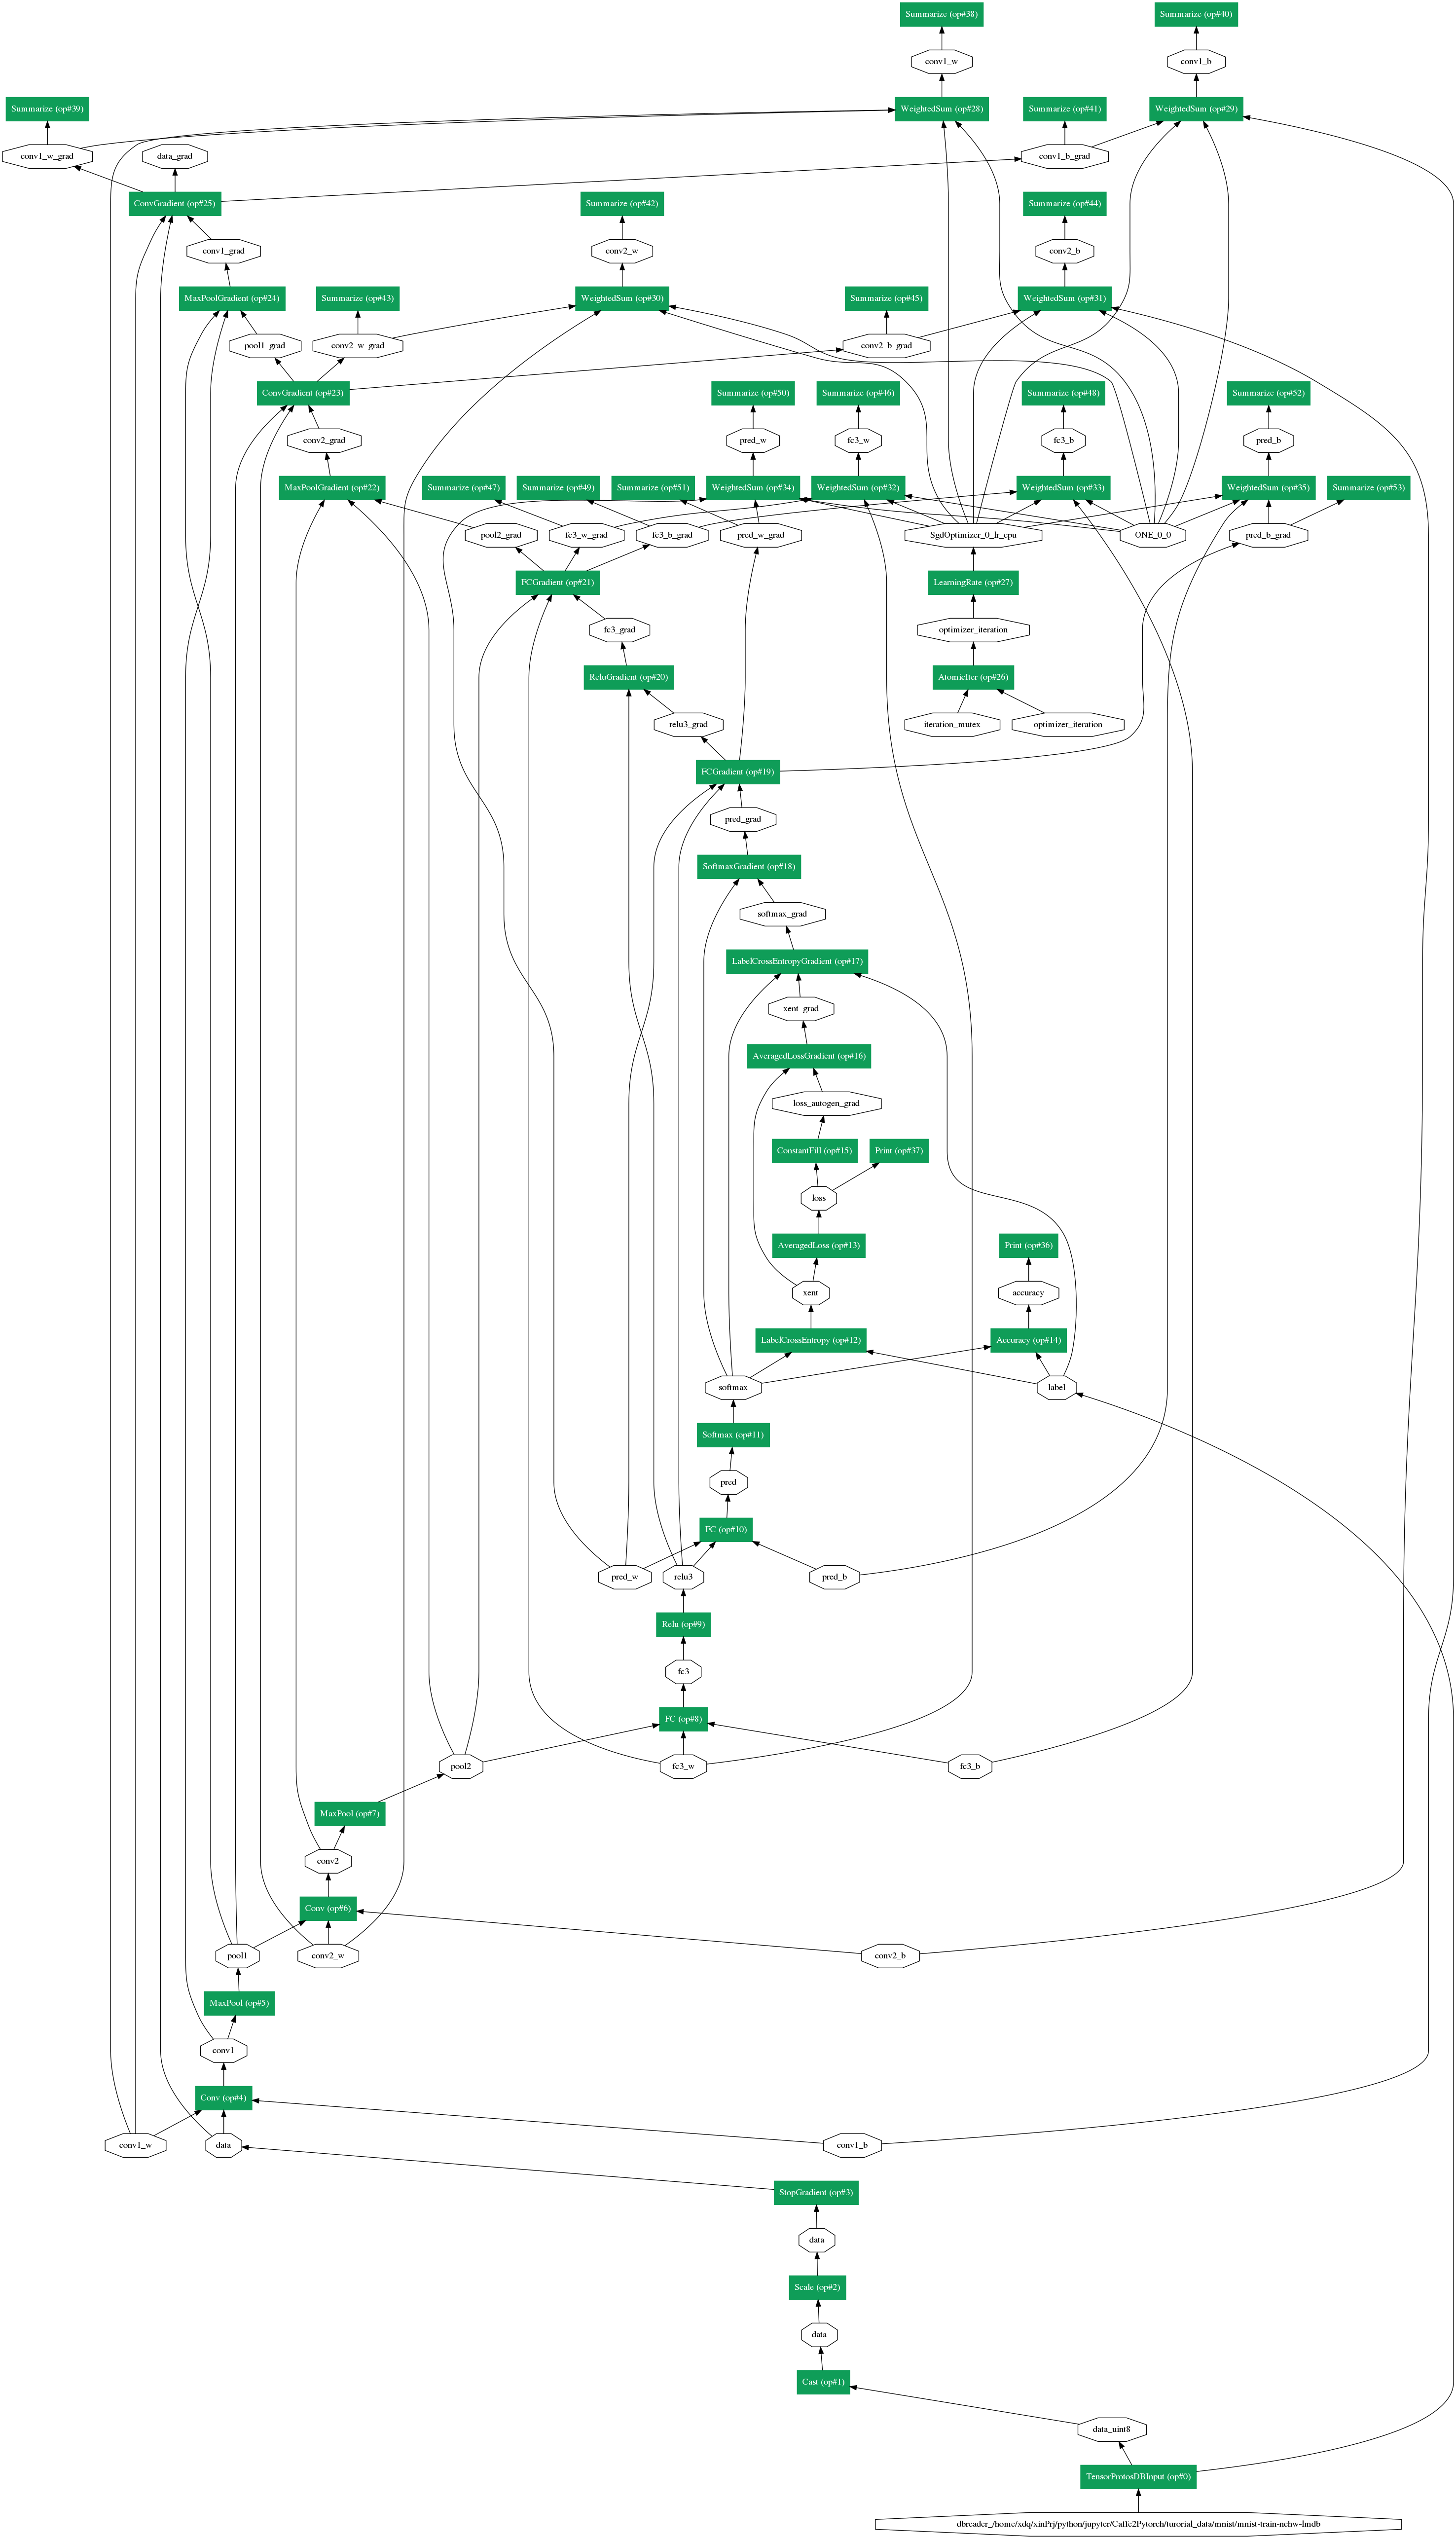

In [12]:
from IPython import display
# graph = net_drawer.GetPydotGraph(train_model.net.Proto().op, "mnist", rankdir="LR")
graph = net_drawer.GetPydotGraph(train_model.net.Proto().op, "mnist", rankdir="BT")
print("graph: {}".format(type(graph.create_png())))
display.Image(graph.create_png(), width=800)


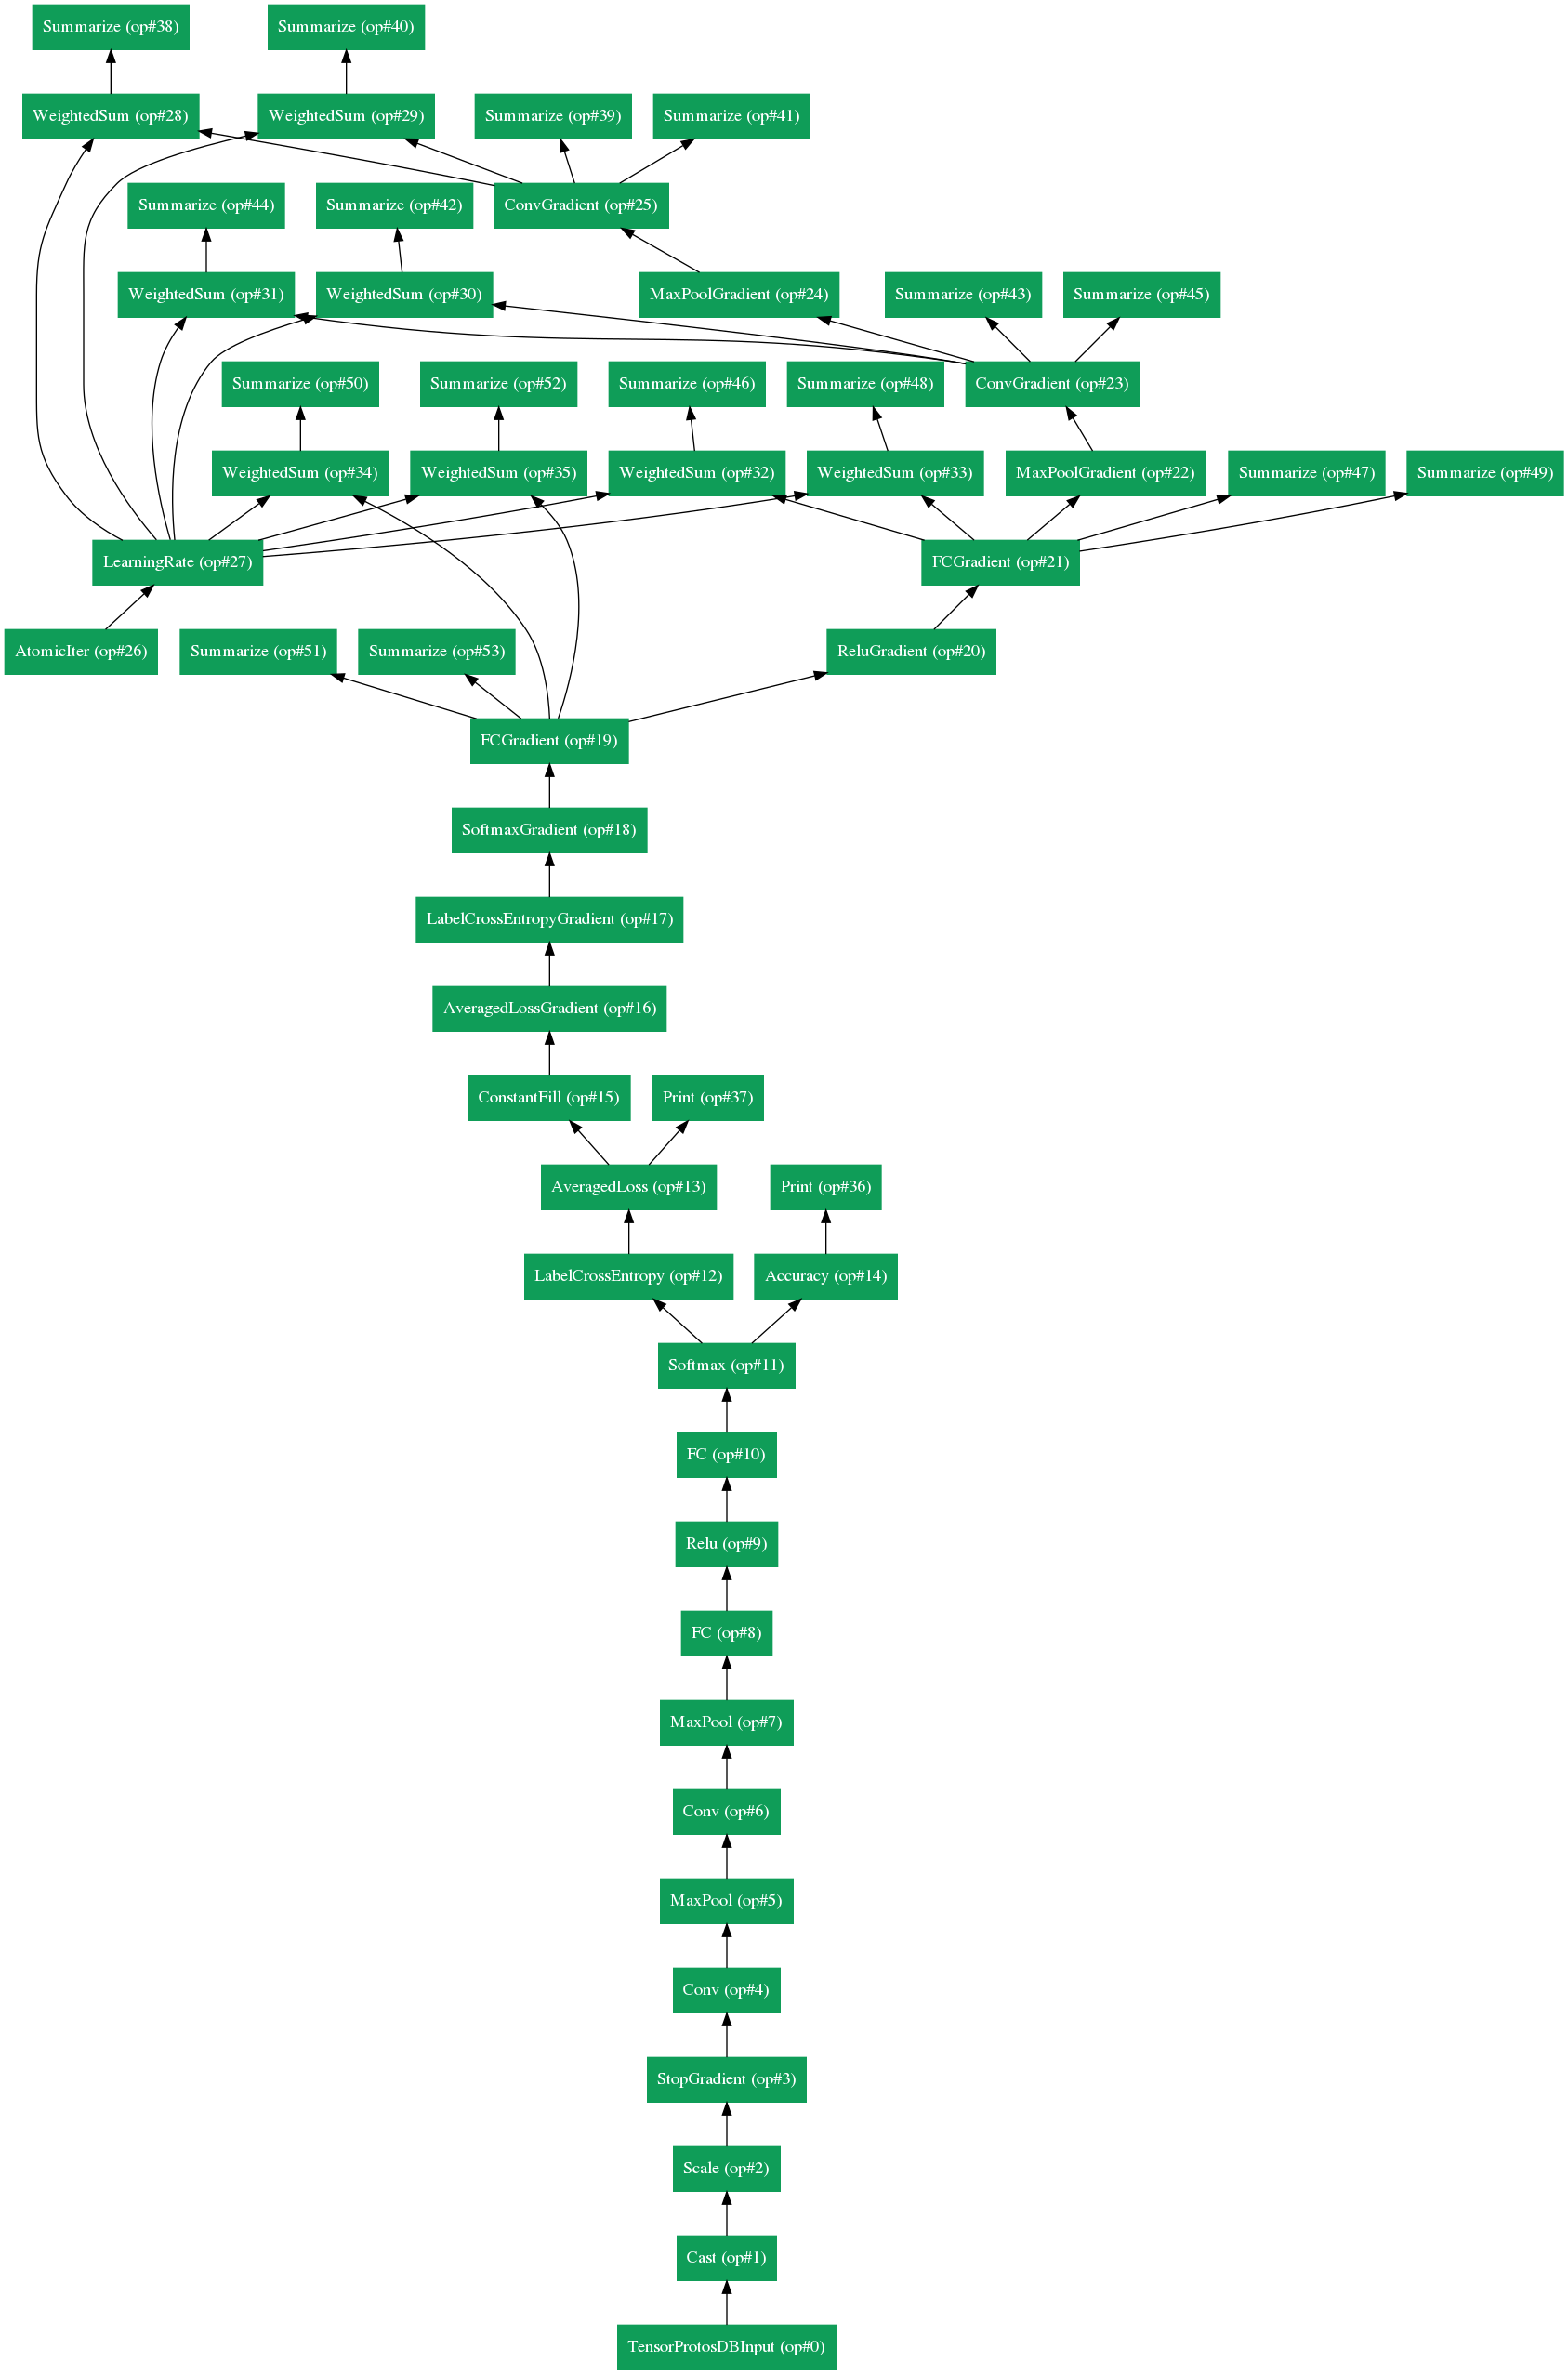

In [13]:
# graph = net_drawer.GetPydotGraphMinimal(train_model.net.Proto().op, "mnist", rankdir="LR", minimal_dependency=True)
graph = net_drawer.GetPydotGraphMinimal(train_model.net.Proto().op, "mnist", rankdir="BT", minimal_dependency=True)
graph.write_png("./images/network_structure_1.png")
display.Image(graph.create_png(), width=800)

In [14]:
print("train_model.net.Proto()\n")
print(str(train_model.net.Proto())[:400]+"\n...")
print("train_model.param_init_net.Proto()\n")
print(str(train_model.param_init_net.Proto())[:400]+"\n...")

train_model.net.Proto()

name: "mnist_train"
op {
  input: "dbreader_/home/xdq/xinPrj/python/jupyter/Caffe2Pytorch/turorial_data/mnist/mnist-train-nchw-lmdb"
  output: "data_uint8"
  output: "label"
  name: ""
  type: "TensorProtosDBInput"
  arg {
    name: "batch_size"
    i: 64
  }
}
op {
  input: "data_uint8"
  output: "data"
  name: ""
  type: "Cast"
  arg {
    name: "to"
    i: 1
  }
}
op {
  input: "data"
  output:
...
train_model.param_init_net.Proto()

name: "mnist_train_init"
op {
  output: "dbreader_/home/xdq/xinPrj/python/jupyter/Caffe2Pytorch/turorial_data/mnist/mnist-train-nchw-lmdb"
  name: ""
  type: "CreateDB"
  arg {
    name: "db"
    s: "/home/xdq/xinPrj/python/jupyter/Caffe2Pytorch/turorial_data/mnist/mnist-train-nchw-lmdb"
  }
  arg {
    name: "db_type"
    s: "lmdb"
  }
}
op {
  output: "conv1_w"
  name: ""
  type: "XavierFill"
  
...


Iter: 0, loss: 2.3962273597717285, accuracy: 0.109375
Iter: 25, loss: 0.45053669810295105, accuracy: 0.859375
Iter: 50, loss: 0.33953601121902466, accuracy: 0.875
Iter: 75, loss: 0.3142191469669342, accuracy: 0.90625
Iter: 100, loss: 0.19107642769813538, accuracy: 0.90625
Iter: 125, loss: 0.2316015213727951, accuracy: 0.921875
Iter: 150, loss: 0.10180190950632095, accuracy: 0.984375
Iter: 175, loss: 0.20034174621105194, accuracy: 0.953125


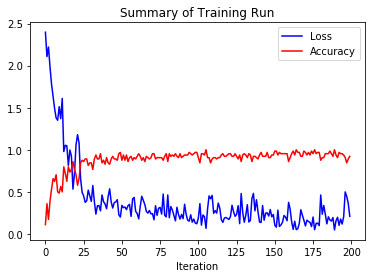

In [15]:
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
total_iters = 200
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    accuracy[i] = workspace.blobs["accuracy"]
    loss[i] = workspace.blobs['loss']
    if i % 25 == 0:
        print("Iter: {}, loss: {}, accuracy: {}".format(i, loss[i], accuracy[i]))
plt.plot(loss, 'b')
plt.plot(accuracy, 'r')
plt.title("Summary of Training Run")
plt.xlabel("Iteration")
plt.legend(("Loss", "Accuracy"), loc="upper right")
plt.savefig("./images/train_loss_accracy.png", format="png")

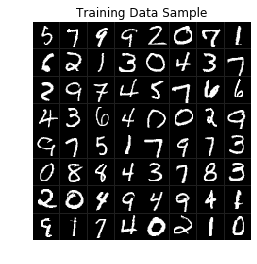

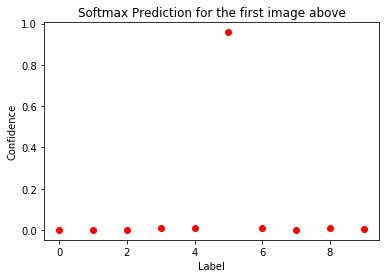

In [16]:
plt.figure()
plt.title("Training Data Sample")
data = workspace.FetchBlob("data")
_ = visualize.NCHW.ShowMultiple(data)
plt.savefig("./images/image_samples.png", format="png")
plt.figure()
plt.title("Softmax Prediction for the first image above")
plt.ylabel("Confidence")
plt.xlabel("Label")

softmax = workspace.FetchBlob('softmax')
_ = plt.plot(softmax[0], 'ro')
plt.savefig("./images/image_sample.png", format="png")

conv shape: (64, 1, 24, 24)


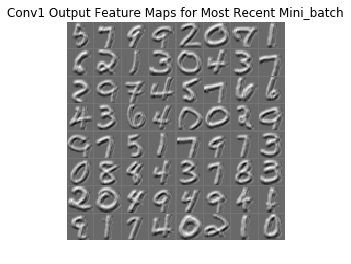

In [17]:
if USE_LENET_MODEL:
    plt.figure()
    plt.title("Conv1 Output Feature Maps for Most Recent Mini_batch")
    conv = workspace.FetchBlob("conv1")
    conv = conv[:, [5], :, :]
#     conv_1 = conv[0][-1]
#     plt.imshow(conv_1, cmap="Greys_r")
    
#     plt.imshow(conv)
#     print("type data: {}".format(type(conv)))
    print("conv shape: {}".format(conv.shape))
#     print("conv1 shape: {}".format(conv_1.shape))
    _ = visualize.NCHW.ShowMultiple(conv)
    plt.savefig("./images/conv1.png", format="png")
#     _ = visualize.NCHW.ShowSingle(conv)
    

test_accuracy: 0.9455000066757202


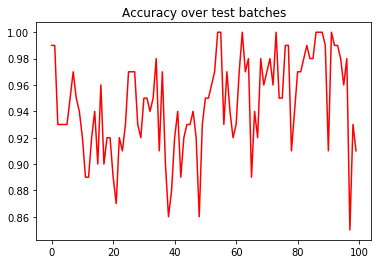

In [18]:
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)
test_accuracy = np.zeros(100)
for i in range(100):
    workspace.RunNet(test_model.net)
    test_accuracy[i] = workspace.FetchBlob("accuracy")
plt.plot(test_accuracy, 'r')
plt.title("Accuracy over test batches")
plt.savefig("./images/accuracy.png", format="png")
print("test_accuracy: {}".format(test_accuracy.mean()))

In [19]:
pe_meta = pe.PredictorExportMeta(
        predict_net=deploy_model.net.Proto(),
        parameters=[str(b) for b in deploy_model.params],
        inputs=["data"],
        outputs=["softmax"],)
pe.save_to_db("minidb", os.path.join(root_folder, "mnist_model.minidb"), pe_meta)
print("Deploy model saved to:" + root_folder + "/mnist_model.minidb")

Deploy model saved to:/home/xdq/xinPrj/python/jupyter/Caffe2Pytorch/turorial_files/tutorial_mnist/mnist_model.minidb


The blobs in the workspace after reset: []
The blobs in the workspace after loading the model: ['!!META_NET_DEF', '!!PREDICTOR_DBREADER', 'conv1', 'conv1_b', 'conv1_w', 'conv2', 'conv2_b', 'conv2_w', 'data', 'fc3', 'fc3_b', 'fc3_w', 'pool1', 'pool2', 'pred', 'pred_b', 'pred_w', 'relu3', 'softmax']
Shape of softmax: (100, 10)
Prediction: 8
Confidence: 0.9558591246604919


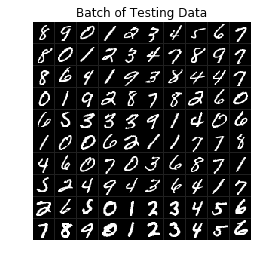

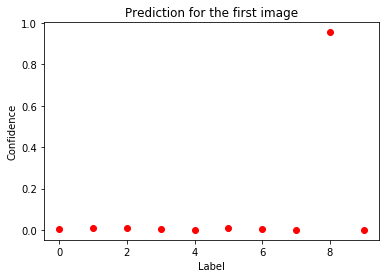

In [20]:
blob = workspace.FetchBlob("data")
plt.figure()
plt.title("Batch of Testing Data")
_ = visualize.NCHW.ShowMultiple(blob)
plt.savefig("./images/test_samples.png", format="png")

workspace.ResetWorkspace(root_folder)
print("The blobs in the workspace after reset: {}".format(workspace.Blobs()))
predict_net = pe.prepare_prediction_net(os.path.join(root_folder, "mnist_model.minidb"), "minidb")
print("The blobs in the workspace after loading the model: {}".format(workspace.Blobs()))
workspace.FeedBlob("data", blob)
workspace.RunNetOnce(predict_net)
softmax = workspace.FetchBlob("softmax")
print("Shape of softmax: {}".format(softmax.shape))
curr_pred, curr_conf = max(enumerate(softmax[0]), key=operator.itemgetter(1))
print("Prediction: {}".format(curr_pred))
print("Confidence: {}".format(curr_conf))
plt.figure()
plt.title("Prediction for the first image")
plt.ylabel("Confidence")
plt.xlabel("Label")
_ = plt.plot(softmax[0], 'ro')
plt.savefig("./images/pre.png", format="png")